# Classifying Adverse Drug Events (ADEs)

In [1]:
import pandas as pd
from datasets import load_dataset
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from IPython.display import display, HTML

In [2]:
# Load dataset 
dataset = load_dataset("SetFit/ade_corpus_v2_classification")
df = dataset['train'].to_pandas()
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


### EDA

In [3]:
# Dataset size (observations and features)
n_obs, n_features = df.shape
print(f"Dataset size: {n_obs} observations, {n_features} features")

Dataset size: 17637 observations, 3 features


In [4]:
# Count of adverse drug events (label=1) vs non–adverse events (label=0)
n_ade = (df["label"] == 1).sum()
n_non_ade = (df["label"] == 0).sum()
print(f"Adverse drug events (label=1): {n_ade}")
print(f"Non–adverse events (label=0): {n_non_ade}")

Adverse drug events (label=1): 5145
Non–adverse events (label=0): 12492


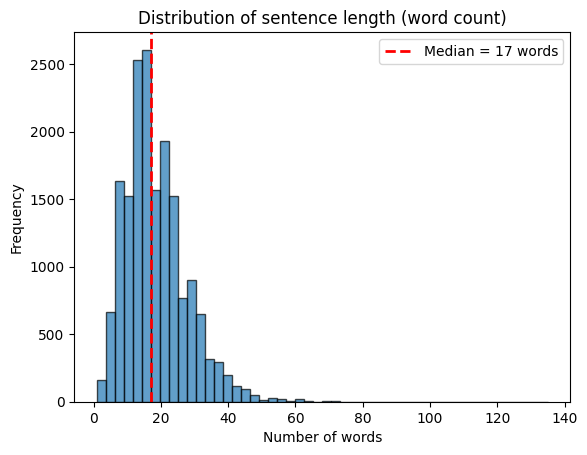

In [5]:
# Histogram of number of words per text, with median
import matplotlib.pyplot as plt

word_counts = df["text"].str.split().str.len()
median_words = word_counts.median()

fig, ax = plt.subplots()
ax.hist(word_counts, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(median_words, color="red", linestyle="--", linewidth=2, label=f"Median = {median_words:.0f} words")
ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of sentence length (word count)")
ax.legend()
plt.show()

### Text Preprocessing

In [6]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/fayewu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fayewu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fayewu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Uses Penn Treebank POS tags to map parts of speech for better lemmatization with WordNet
def _get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  


def preprocess_text(text):
    """Lowercase, normalize whitespace, tokenize, remove punctuation/digits-only tokens, and lemmatize (POS-aware)."""
    if not isinstance(text, str) or not text.strip():
        return ''
    # Lowercase and normalize whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove tokens that are only punctuation/digits
    tokens = [t for t in tokens if re.search(r'[a-z]', t)]
    if not tokens:
        return ''

    # POS tag for better lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(token, pos=_get_wordnet_pos(tag))
        for token, tag in pos_tags
    ]
    return ' '.join(lemmatized)


df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,label,label_text,processed_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...
1,Median patient age was 52 years.,0,Not-Related,median patient age be year
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...


### Information Extraction (NER)
- Use the scispaCy BC5CDR model to extract chemicals and diseases from the raw 'text' column
- These chemicals and diseases can be used as extra information for a classification model

In [8]:
# scispaCy BC5CDR model: CHEMICAL (drugs) and DISEASE (conditions/adverse effects)
nlp = spacy.load("en_ner_bc5cdr_md")


def extract_ner_entities(text):
    """Extract drug (chemical) and disease/condition entities from text using scispaCy NER."""
    if not isinstance(text, str) or not text.strip():
        return [], []
    doc = nlp(text)
    drugs = [ent.text for ent in doc.ents if ent.label_ == "CHEMICAL"]
    diseases = [ent.text for ent in doc.ents if ent.label_ == "DISEASE"]
    return drugs, diseases


# Copy df and add NER-derived columns
df_ner = df.copy()
ner_results = df_ner["text"].apply(extract_ner_entities)
df_ner["drug_entities"] = [r[0] for r in ner_results]
df_ner["disease_entities"] = [r[1] for r in ner_results]

df_ner.head()

/opt/anaconda3/envs/pharma/lib/python3.8/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,text,label,label_text,processed_text,drug_entities,disease_entities
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...,[],[]
1,Median patient age was 52 years.,0,Not-Related,median patient age be year,[],[]
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...,"[gefitinib, erlotinib]",[]
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...,[],"[hypocalcemia, hypoparathyroidism, leukemia]"
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...,[charcoal yeast extract],[]


#### NER Validation
- Taking samples of text and visualizing how the scispaCy model is classifying diseases and chemicals

In [9]:
from spacy import displacy
# Select a few random examples
sample_docs = df_ner[df_ner['drug_entities'].map(len) > 0].sample(5)['text']

for text in sample_docs:
    doc = nlp(text)
    
    # 1. Generate the HTML string with jupyter=False
    html = displacy.render(doc, style="ent", jupyter=False)
    
    # 2. Manually display the HTML using the correct import
    display(HTML(html))
    
    print("---")

---


---


---


---


---


## Classification Modeling

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
class NERFeatureExtractor(BaseEstimator, TransformerMixin):
    # Custom transformer to extract NER-based features
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract NER features from dataframe
        features = []
        for _, row in X.iterrows():
            # Binary features for presence of drugs/diseases
            has_drug = 1 if len(row['drug_entities']) > 0 else 0
            has_disease = 1 if len(row['disease_entities']) > 0 else 0
            
            # Count features
            drug_count = len(row['drug_entities'])
            disease_count = len(row['disease_entities'])
            
            # Combined feature: presence of both drug and disease
            has_both = 1 if (has_drug and has_disease) else 0
            
            features.append([has_drug, has_disease, drug_count, disease_count, has_both])
        
        return np.array(features)

# Prepare the data for modeling
df_model = df_ner.copy()

# Create features: text + NER features
X_text = df_model['processed_text'].values
X_ner_features = df_model[['drug_entities', 'disease_entities']]
y = df_model['label'].values

print(f"Dataset shape: {df_model.shape}")
print(f"Positive samples (ADE): {y.sum()}")
print(f"Negative samples: {len(y) - y.sum()}")

Dataset shape: (17637, 6)
Positive samples (ADE): 5145
Negative samples: 12492


In [12]:
# BASELINE MODELS
# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Define baseline models
baseline_models = {
    'Naive Bayes': GaussianNB(),  # Using Gaussian NB for continuous TF-IDF features
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Train and evaluate baseline models
baseline_results = {}
for name, model in baseline_models.items():
    # GaussianNB requires dense arrays, convert sparse TF-IDF to dense
    if isinstance(model, GaussianNB):
        X_train_features = X_train_tfidf.toarray()
        X_test_features = X_test_tfidf.toarray()
    else:
        X_train_features = X_train_tfidf
        X_test_features = X_test_tfidf
    
    # Train model
    model.fit(X_train_features, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_features)
    y_pred_proba = model.predict_proba(X_test_features)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    baseline_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Training samples: 14109
Test samples: 3528

Naive Bayes:
  Accuracy: 0.6845
  Precision: 0.4780
  Recall: 0.8853
  F1-Score: 0.6208

Logistic Regression:
  Accuracy: 0.8509
  Precision: 0.7036
  Recall: 0.8445
  F1-Score: 0.7677

Random Forest:
  Accuracy: 0.8719
  Precision: 0.8312
  Recall: 0.7036
  F1-Score: 0.7621

KNN:
  Accuracy: 0.7707
  Precision: 0.8873
  Recall: 0.2449
  F1-Score: 0.3839

SVM:
  Accuracy: 0.8741
  Precision: 0.8204
  Recall: 0.7279
  F1-Score: 0.7714


The dataset has 70.8% negative (non-ADE) and 29.2% positive (ADE) samples. class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies, penalizing misclassifications of minority class more heavily.

In [13]:
# Prepare combined dataset with NER features
X_combined = df_model[['processed_text', 'drug_entities', 'disease_entities']]
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Custom transformer for combined features
class CombinedFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        self.ner_extractor = NERFeatureExtractor()
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        # Fit TF-IDF on text
        self.tfidf.fit(X['processed_text'])
        
        # Fit scaler on NER features
        ner_features = self.ner_extractor.transform(X)
        self.scaler.fit(ner_features)
        
        return self
    
    def transform(self, X):
        # Transform text
        text_features = self.tfidf.transform(X['processed_text'])
        
        # Transform NER features
        ner_features = self.ner_extractor.transform(X)
        ner_features_scaled = self.scaler.transform(ner_features)
        
        # Combine features
        from scipy.sparse import hstack
        return hstack([text_features, ner_features_scaled])

# Create pipeline with combined features
combined_models = {
    'Naive Bayes (NER)': GaussianNB(),
    'Logistic Regression (NER)': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest (NER)': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'KNN (NER)': KNeighborsClassifier(n_neighbors=5),
    'SVM (NER)': SVC(kernel='linear', random_state=42, probability=True)
}

# Custom transformer to convert sparse to dense for models that require it
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert sparse matrix to dense array
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

combined_results = {}
for name, model in combined_models.items():
    # GaussianNB requires dense arrays, add densifier to pipeline
    if isinstance(model, GaussianNB):
        pipeline = Pipeline([
            ('features', CombinedFeaturesTransformer()),
            ('densify', DenseTransformer()),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('features', CombinedFeaturesTransformer()),
            ('classifier', model)
        ])
    
    # Train
    pipeline.fit(X_train_combined, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test_combined)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    combined_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': pipeline
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Naive Bayes (NER):
  Accuracy: 0.7160
  Precision: 0.5078
  Recall: 0.8562
  F1-Score: 0.6375

Logistic Regression (NER):
  Accuracy: 0.8645
  Precision: 0.7157
  Recall: 0.8882
  F1-Score: 0.7927

Random Forest (NER):
  Accuracy: 0.8892
  Precision: 0.7916
  Recall: 0.8416
  F1-Score: 0.8158

KNN (NER):
  Accuracy: 0.8424
  Precision: 0.7344
  Recall: 0.7201
  F1-Score: 0.7272

SVM (NER):
  Accuracy: 0.8900
  Precision: 0.8189
  Recall: 0.7998
  F1-Score: 0.8092


In [14]:
# NER-ONLY MODELS
# Train models using only NER-derived features (no text vectorization)
print("MODELS WITH NER FEATURES ONLY")

# Extract NER features
ner_extractor = NERFeatureExtractor()
X_train_ner = ner_extractor.fit_transform(X_train_combined)
X_test_ner = ner_extractor.transform(X_test_combined)

# Scale NER features for better performance
scaler_ner = StandardScaler()
X_train_ner_scaled = scaler_ner.fit_transform(X_train_ner)
X_test_ner_scaled = scaler_ner.transform(X_test_ner)

# Define models appropriate for NER features
# These models work well with small feature sets
ner_only_models = {
    'Naive Bayes (NER)': GaussianNB(),  # Gaussian NB for continuous scaled features
    'Logistic Regression (NER)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest (NER)': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (NER)': SVC(kernel='rbf', random_state=42, probability=True),  # RBF kernel for non-linear relationships
    'KNN (NER)': KNeighborsClassifier(n_neighbors=5)
}

ner_only_results = {}
for name, model in ner_only_models.items():
    # Train model
    model.fit(X_train_ner_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_ner_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    ner_only_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

MODELS WITH NER FEATURES ONLY

Naive Bayes (NER):
  Accuracy: 0.7874
  Precision: 0.6084
  Recall: 0.7609
  F1-Score: 0.6762

Logistic Regression (NER):
  Accuracy: 0.7914
  Precision: 0.6160
  Recall: 0.7561
  F1-Score: 0.6789

Random Forest (NER):
  Accuracy: 0.7985
  Precision: 0.6893
  Recall: 0.5627
  F1-Score: 0.6196

SVM (NER):
  Accuracy: 0.7993
  Precision: 0.6895
  Recall: 0.5675
  F1-Score: 0.6226

KNN (NER):
  Accuracy: 0.7809
  Precision: 0.6081
  Recall: 0.6997
  F1-Score: 0.6507


In [16]:
# HYPERPARAMETER TUNING FOR RANDOM FOREST
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [15, 20, 25, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
    'classifier__bootstrap': [True, False]
}

# Create pipeline for tuned model
rf_tuning_pipeline = Pipeline([
    ('features', CombinedFeaturesTransformer()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Use stratified k-fold to maintain class distribution
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    rf_tuning_pipeline, 
    param_grid, 
    cv=cv,
    scoring='f1',  # Optimize for F1 score (balances precision/recall)
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters...")
grid_search.fit(X_train_combined, y_train)

print(f"\n Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
best_tuned_rf = grid_search.best_estimator_
y_pred_tuned = best_tuned_rf.predict(X_test_combined)
y_pred_proba_tuned = best_tuned_rf.predict_proba(X_test_combined)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned, recall_tuned, f1_tuned, _ = precision_recall_fscore_support(y_test, y_pred_tuned, average='binary')

print(f"\n Tuned Random Forest Performance:")
print(f"  Accuracy: {accuracy_tuned:.4f}")
print(f"  Precision: {precision_tuned:.4f}")
print(f"  Recall: {recall_tuned:.4f}")
print(f"  F1-Score: {f1_tuned:.4f}")

# Compare with untuned model
print(f"\n Improvement over untuned Random Forest:")
print(f"  Accuracy: {accuracy_tuned - combined_results['Random Forest (NER)']['accuracy']:+.4f}")
print(f"  Precision: {precision_tuned - combined_results['Random Forest (NER)']['precision']:+.4f}")
print(f"  Recall: {recall_tuned - combined_results['Random Forest (NER)']['recall']:+.4f}")
print(f"  F1: {f1_tuned - combined_results['Random Forest (NER)']['f1']:+.4f}")

Tuning hyperparameters...
Fitting 3 folds for each of 648 candidates, totalling 1944 fits

 Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best cross-validation F1 score: 0.8061

 Tuned Random Forest Performance:
  Accuracy: 0.9045
  Precision: 0.8314
  Recall: 0.8435
  F1-Score: 0.8374

 Improvement over untuned Random Forest:
  Accuracy: +0.0153
  Precision: +0.0398
  Recall: +0.0019
  F1: +0.0216


In [18]:
# EVALUATING BEST MODEL WITH BIGRAMS

# Create a custom transformer for bigrams without modifying the original class
class BigramFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        self.ner_extractor = NERFeatureExtractor()
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.tfidf.fit(X['processed_text'])
        ner_features = self.ner_extractor.transform(X)
        self.scaler.fit(ner_features)
        return self
    
    def transform(self, X):
        text_features = self.tfidf.transform(X['processed_text'])
        ner_features = self.ner_extractor.transform(X)
        ner_features_scaled = self.scaler.transform(ner_features)
        from scipy.sparse import hstack
        return hstack([text_features, ner_features_scaled])

# Use best parameters from tuning
best_params = grid_search.best_params_
rf_params = {k.replace('classifier__', ''): v for k, v in best_params.items()}

# Create pipeline with bigrams
bigram_pipeline = Pipeline([
    ('features', BigramFeaturesTransformer()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', **rf_params))
])

print("Training with unigrams + bigrams...")
bigram_pipeline.fit(X_train_combined, y_train)

y_pred_bigram = bigram_pipeline.predict(X_test_combined)
accuracy_bigram = accuracy_score(y_test, y_pred_bigram)
precision_bigram, recall_bigram, f1_bigram, _ = precision_recall_fscore_support(y_test, y_pred_bigram, average='binary')

print(f"\n Bigram Model Performance:")
print(f"  Accuracy: {accuracy_bigram:.4f}")
print(f"  Precision: {precision_bigram:.4f}")
print(f"  Recall: {recall_bigram:.4f}")
print(f"  F1-Score: {f1_bigram:.4f}")

print(f"\n Improvement over unigram Random Forest:")
print(f"  F1 Improvement: {f1_bigram - combined_results['Random Forest (NER)']['f1']:+.4f}")

Training with unigrams + bigrams...

 Bigram Model Performance:
  Accuracy: 0.9045
  Precision: 0.8314
  Recall: 0.8435
  F1-Score: 0.8374

 Improvement over unigram Random Forest:
  F1 Improvement: +0.0216


Using Tuned model for threshold tuning

 Default threshold (0.5) performance (closest value: 0.50):
  Recall: 0.8435
  Precision: 0.8314
  F1: 0.8374
  False Negatives: 161

 Best threshold by F1-score: 0.48
  F1: 0.8420
  Recall: 0.8649
  Precision: 0.8203
  False Negatives: 139

 Best threshold for minimizing false negatives (recall ≥ 85%): 0.10
  F1: 0.5776
  Recall: 0.9951
  Precision: 0.4068
  False Negatives: 5
  False Positives: 1493


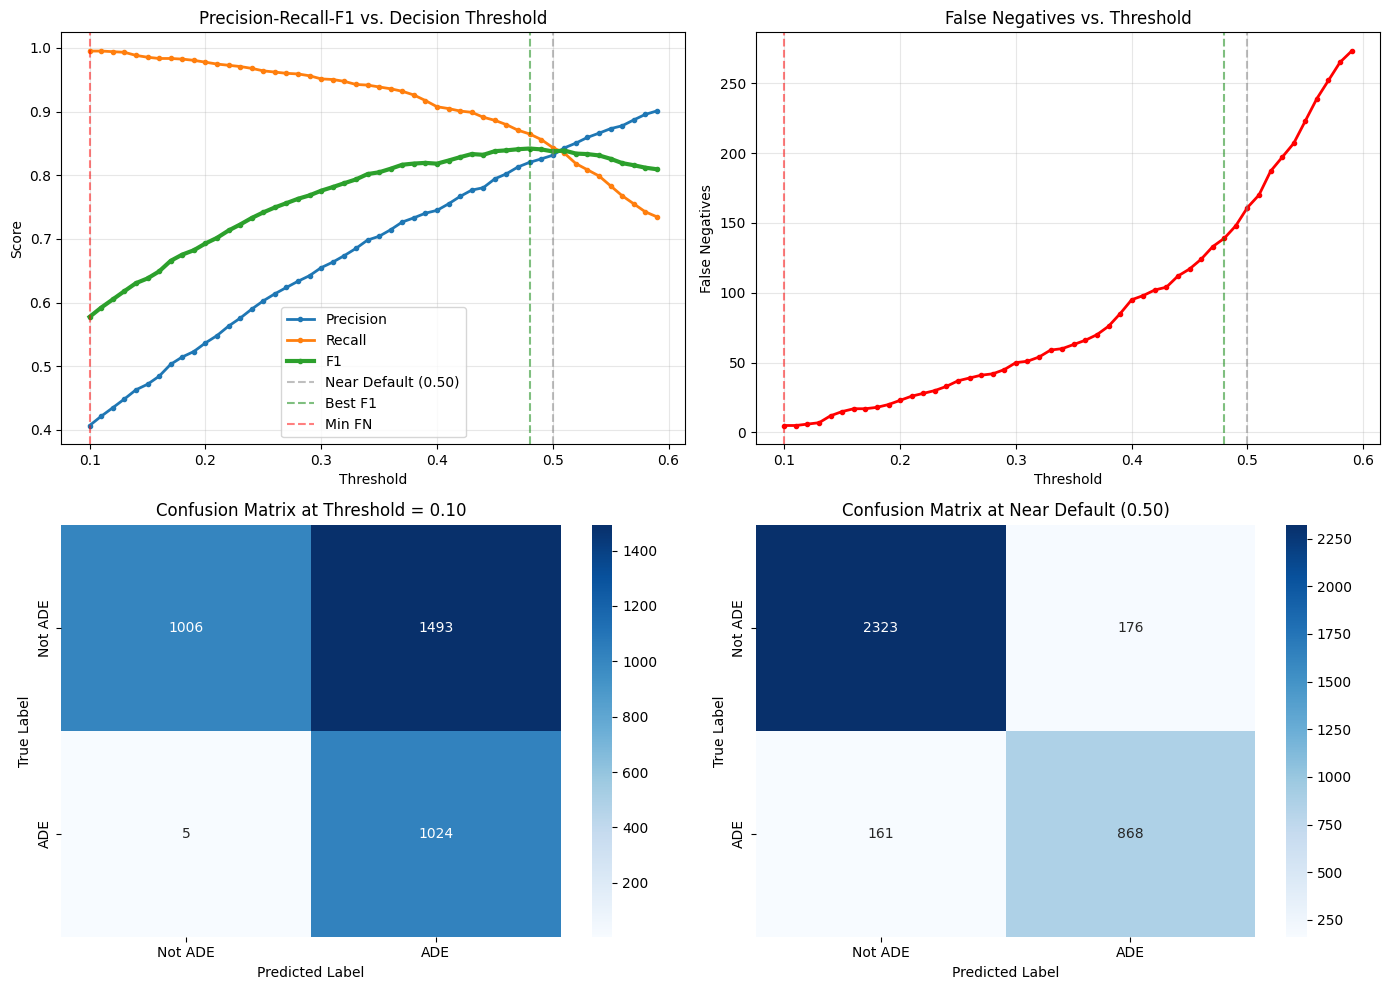

In [20]:
# THRESHOLD TUNING TO MINIMIZE FALSE NEGATIVES
# Use the best model (prefer bigram if it improved, otherwise tuned model)
if f1_bigram > f1_tuned:
    print("Using Bigram model for threshold tuning")
    best_model_for_threshold = bigram_pipeline
    best_model_name = "Random Forest (Bigrams)"
    best_f1 = f1_bigram
else:
    print("Using Tuned model for threshold tuning")
    best_model_for_threshold = best_tuned_rf
    best_model_name = "Random Forest (Tuned)"
    best_f1 = f1_tuned

# Get probability predictions
y_proba = best_model_for_threshold.predict_proba(X_test_combined)[:, 1]

# Try different thresholds (focus on lower thresholds to catch more ADEs)
thresholds = np.arange(0.1, 0.6, 0.01)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    
    # False negative rate = FN / (FN + TP)
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fn': fn,
        'fp': fp,
        'fn_rate': fn_rate,
        'tp': tp
    })

results_df = pd.DataFrame(results)

# Find best threshold based on F1 score
best_idx = results_df['f1'].idxmax()
best_threshold_f1 = results_df.loc[best_idx]

# Find threshold with minimum false negatives (subject to minimum recall)
# In pharmacovigilance, we want to catch as many ADEs as possible
min_fn_threshold = results_df[results_df['recall'] >= 0.85].sort_values('fn').iloc[0]

# Fix: Find closest threshold to 0.5 instead of exact match
closest_to_05 = results_df.iloc[(results_df['threshold'] - 0.5).abs().argsort()[:1]].iloc[0]

print(f"\n Default threshold (0.5) performance (closest value: {closest_to_05['threshold']:.2f}):")
print(f"  Recall: {closest_to_05['recall']:.4f}")
print(f"  Precision: {closest_to_05['precision']:.4f}")
print(f"  F1: {closest_to_05['f1']:.4f}")
print(f"  False Negatives: {int(closest_to_05['fn'])}")

print(f"\n Best threshold by F1-score: {best_threshold_f1['threshold']:.2f}")
print(f"  F1: {best_threshold_f1['f1']:.4f}")
print(f"  Recall: {best_threshold_f1['recall']:.4f}")
print(f"  Precision: {best_threshold_f1['precision']:.4f}")
print(f"  False Negatives: {int(best_threshold_f1['fn'])}")

print(f"\n Best threshold for minimizing false negatives (recall ≥ 85%): {min_fn_threshold['threshold']:.2f}")
print(f"  F1: {min_fn_threshold['f1']:.4f}")
print(f"  Recall: {min_fn_threshold['recall']:.4f}")
print(f"  Precision: {min_fn_threshold['precision']:.4f}")
print(f"  False Negatives: {int(min_fn_threshold['fn'])}")
print(f"  False Positives: {int(min_fn_threshold['fp'])}")

# Visualize threshold impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Metrics vs Threshold
ax1 = axes[0, 0]
ax1.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='.', linewidth=2)
ax1.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='.', linewidth=2)
ax1.plot(results_df['threshold'], results_df['f1'], label='F1', marker='.', linewidth=3)
ax1.axvline(x=closest_to_05['threshold'], color='gray', linestyle='--', alpha=0.5, label=f'Near Default ({closest_to_05["threshold"]:.2f})')
ax1.axvline(x=best_threshold_f1['threshold'], color='green', linestyle='--', alpha=0.5, label=f"Best F1")
ax1.axvline(x=min_fn_threshold['threshold'], color='red', linestyle='--', alpha=0.5, label=f"Min FN")
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision-Recall-F1 vs. Decision Threshold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: False Negatives vs Threshold
ax2 = axes[0, 1]
ax2.plot(results_df['threshold'], results_df['fn'], marker='.', color='red', linewidth=2)
ax2.axvline(x=closest_to_05['threshold'], color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=best_threshold_f1['threshold'], color='green', linestyle='--', alpha=0.5)
ax2.axvline(x=min_fn_threshold['threshold'], color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('False Negatives')
ax2.set_title('False Negatives vs. Threshold')
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix at optimal threshold
ax3 = axes[1, 0]
y_pred_optimal = (y_proba >= min_fn_threshold['threshold']).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Not ADE', 'ADE'], 
            yticklabels=['Not ADE', 'ADE'])
ax3.set_title(f'Confusion Matrix at Threshold = {min_fn_threshold["threshold"]:.2f}')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# Plot 4: Original confusion matrix for comparison
ax4 = axes[1, 1]
y_pred_default = (y_proba >= closest_to_05['threshold']).astype(int)
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Not ADE', 'ADE'], 
            yticklabels=['Not ADE', 'ADE'])
ax4.set_title(f'Confusion Matrix at Near Default ({closest_to_05["threshold"]:.2f})')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

Optimal threshold at 0.48 achieves best F1 (0.842) with strong recall (86.5%) and precision (82.0%). Threshold at 0.10 catches nearly all ADEs (99.5% recall) but at cost of many false positives (1493), which may be acceptable depending on use case.

/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_49461/776947216.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_49461/776947216.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_49461/776947216.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_49461/776947216.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


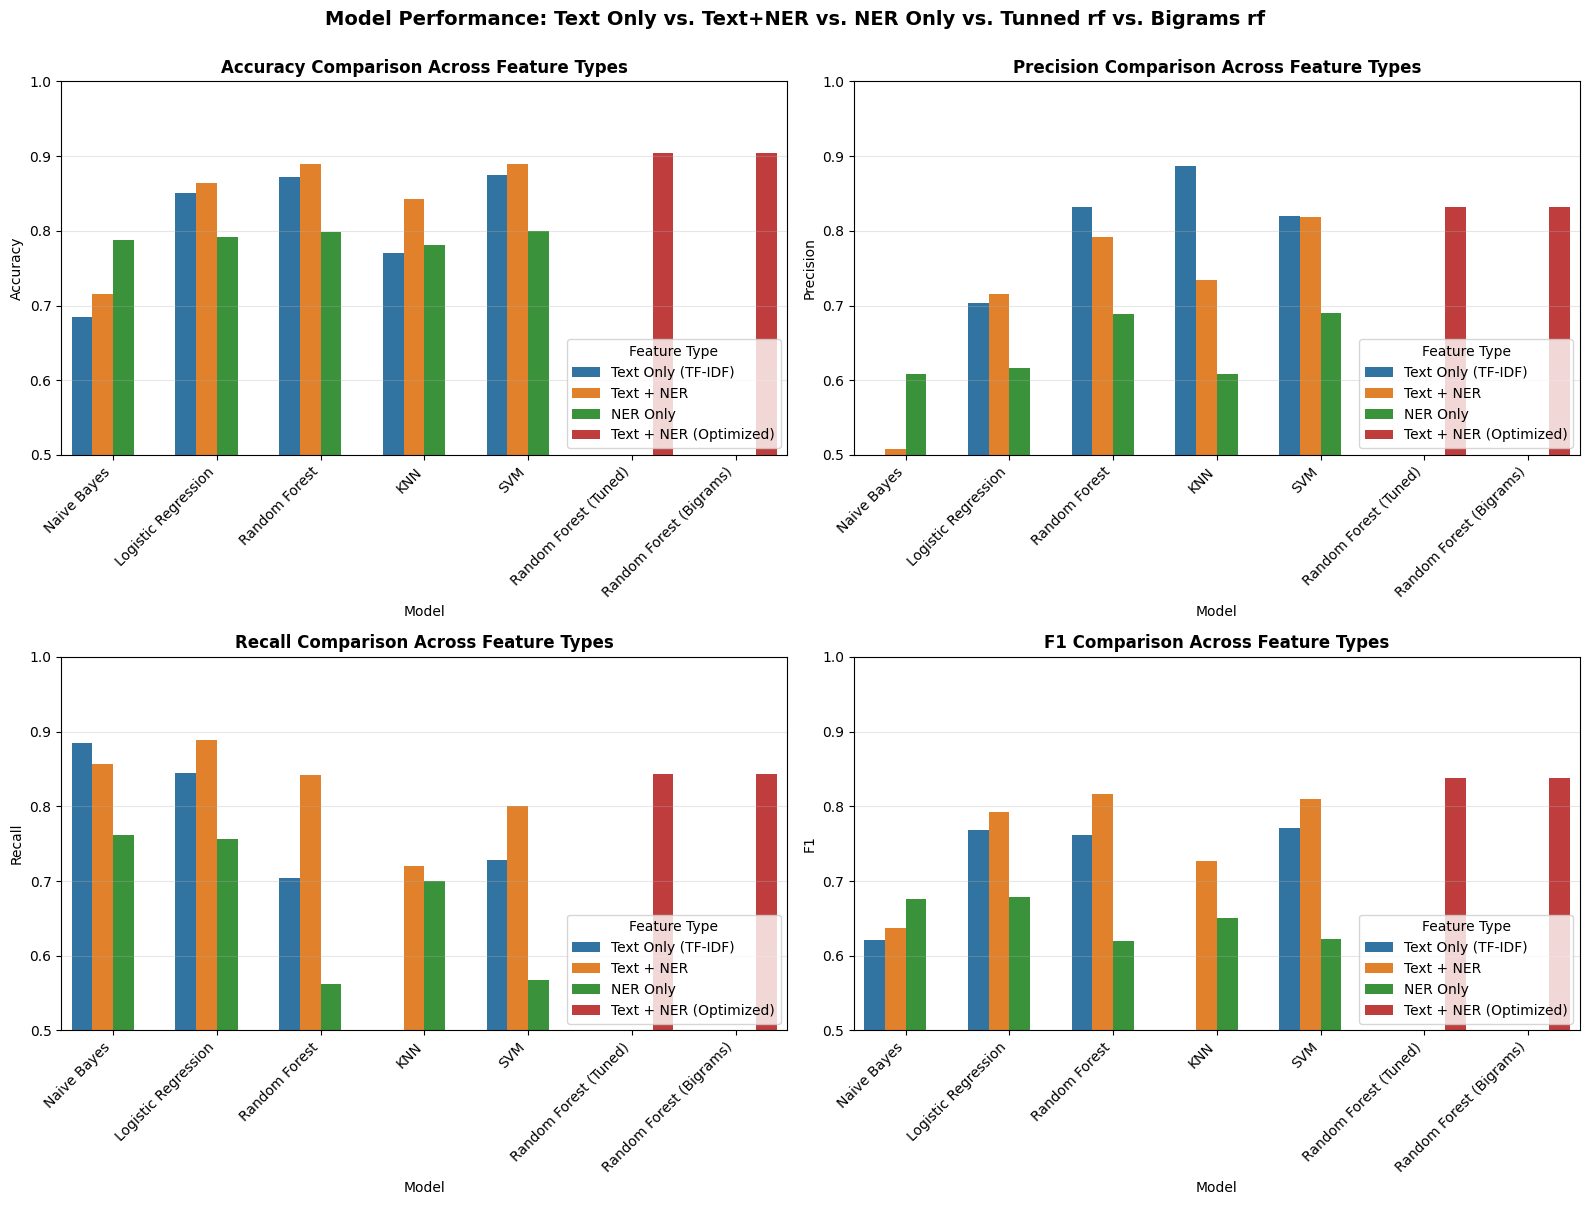

In [22]:
# COMPARISON VISUALIZATION
# Compare all three types of models: Baseline (text only), Combined (text + NER), NER-only
comparison_data = []

# Baseline models (text only)
for name, results in baseline_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'Text Only (TF-IDF)'
    })

# Combined models (text + NER)
for name, results in combined_results.items():
    model_base = name.replace(' (NER)', '')
    comparison_data.append({
        'Model': model_base,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'Text + NER'
    })

# NER-only models
for name, results in ner_only_results.items():
    model_base = name.replace(' (NER)', '')
    comparison_data.append({
        'Model': model_base,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'NER Only'
    })

# Add tuned and bigram models to comparison
comparison_data.append({
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_tuned,
    'Precision': precision_tuned,
    'Recall': recall_tuned,
    'F1': f1_tuned,
    'Type': 'Text + NER (Optimized)'
})

comparison_data.append({
    'Model': 'Random Forest (Bigrams)',
    'Accuracy': accuracy_bigram,
    'Precision': precision_bigram,
    'Recall': recall_bigram,
    'F1': f1_bigram,
    'Type': 'Text + NER (Optimized)'
})

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison - all three types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sns.barplot(data=comparison_df, x='Model', y=metric, hue='Type', ax=ax)
    ax.set_title(f'{metric} Comparison Across Feature Types', fontsize=12, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.5, 1.0)
    ax.legend(title='Feature Type', loc='lower right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance: Text Only vs. Text+NER vs. NER Only vs. Tunned rf vs. Bigrams rf', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [25]:
# Summary statistics by feature type
summary_stats = comparison_df.groupby('Type')[['Accuracy', 'Precision', 'Recall', 'F1']].agg(['mean', 'std'])
print(summary_stats.round(4))

# Best model for each type
print("BEST MODEL FOR EACH FEATURE TYPE")

# Include all feature types including optimized ones
feature_types = ['Text Only (TF-IDF)', 'Text + NER', 'NER Only', 'Text + NER (Optimized)']

for feature_type in feature_types:
    subset = comparison_df[comparison_df['Type'] == feature_type]
    if len(subset) > 0:  # Check if this type exists in the data
        best_idx = subset['F1'].idxmax()
        best_row = subset.loc[best_idx]
        print(f"\n{feature_type}:")
        print(f"  Best Model: {best_row['Model']}")
        print(f"  Accuracy: {best_row['Accuracy']:.4f}")
        print(f"  Precision: {best_row['Precision']:.4f}")
        print(f"  Recall: {best_row['Recall']:.4f}")
        print(f"  F1-Score: {best_row['F1']:.4f}")

                       Accuracy         Precision          Recall          \
                           mean     std      mean     std    mean     std   
Type                                                                        
NER Only                 0.7915  0.0077    0.6423  0.0431  0.6694  0.0982   
Text + NER               0.8404  0.0723    0.7137  0.1224  0.8212  0.0648   
Text + NER (Optimized)   0.9045  0.0000    0.8314  0.0000  0.8435  0.0000   
Text Only (TF-IDF)       0.8104  0.0820    0.7441  0.1631  0.6812  0.2556   

                            F1          
                          mean     std  
Type                                    
NER Only                0.6496  0.0283  
Text + NER              0.7565  0.0752  
Text + NER (Optimized)  0.8374  0.0000  
Text Only (TF-IDF)      0.6612  0.1675  
BEST MODEL FOR EACH FEATURE TYPE

Text Only (TF-IDF):
  Best Model: SVM
  Accuracy: 0.8741
  Precision: 0.8204
  Recall: 0.7279
  F1-Score: 0.7714

Text + NER:
  Best Model:


 Best Overall Model: Random Forest (Tuned) (Text + NER (Optimized))
  Accuracy: 0.9045
  Precision: 0.8314
  Recall: 0.8435
  F1-Score: 0.8374
  Using Tuned model

 Classification Report:
              precision    recall  f1-score   support

     Not ADE       0.94      0.93      0.93      2499
         ADE       0.83      0.84      0.84      1029

    accuracy                           0.90      3528
   macro avg       0.88      0.89      0.88      3528
weighted avg       0.90      0.90      0.90      3528



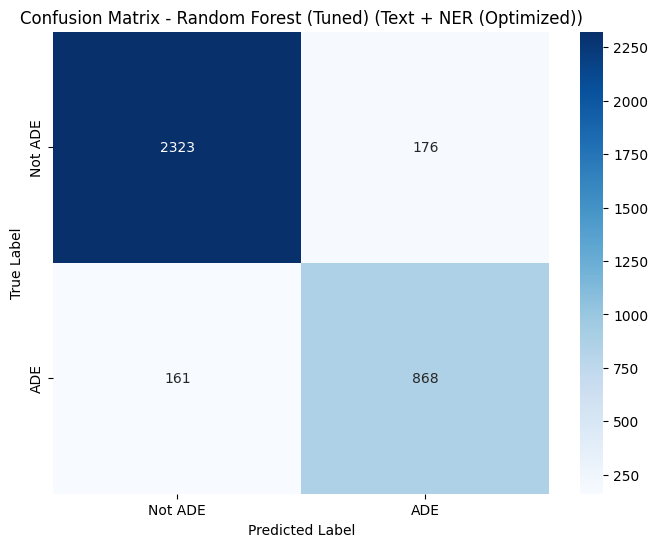

In [27]:
# OVERALL BEST MODEL SELECTION
best_idx = comparison_df['F1'].idxmax()
best_row = comparison_df.loc[best_idx]
best_feature_type = best_row['Type']

print(f"\n Best Overall Model: {best_row['Model']} ({best_feature_type})")
print(f"  Accuracy: {best_row['Accuracy']:.4f}")
print(f"  Precision: {best_row['Precision']:.4f}")
print(f"  Recall: {best_row['Recall']:.4f}")
print(f"  F1-Score: {best_row['F1']:.4f}")

# Get the actual model based on type
if best_feature_type == 'Text Only (TF-IDF)':
    best_model = baseline_results[best_row['Model']]['model']
    X_test_eval = X_test_tfidf
    if isinstance(best_model, GaussianNB):
        X_test_eval = X_test_tfidf.toarray()
        
elif best_feature_type == 'Text + NER':
    model_name = best_row['Model'] + ' (NER)'
    best_model = combined_results[model_name]['model']
    X_test_eval = X_test_combined
    
elif best_feature_type == 'NER Only':
    model_name = best_row['Model'] + ' (NER)'
    best_model = ner_only_results[model_name]['model']
    X_test_eval = X_test_ner_scaled
    
elif best_feature_type == 'Text + NER (Optimized)':
    # These are our tuned/bigram models - access them directly
    if 'Bigrams' in best_row['Model']:
        best_model = bigram_pipeline
        print("  Using Bigram model")
    elif 'Tuned' in best_row['Model']:
        best_model = best_tuned_rf
        print("  Using Tuned model")
    else:
        best_model = bigram_pipeline  # default to bigram
    X_test_eval = X_test_combined

# Generate predictions
y_pred = best_model.predict(X_test_eval)
y_pred_proba = best_model.predict_proba(X_test_eval)[:, 1]

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not ADE', 'ADE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not ADE', 'ADE'], 
            yticklabels=['Not ADE', 'ADE'])
plt.title(f'Confusion Matrix - {best_row["Model"]} ({best_feature_type})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

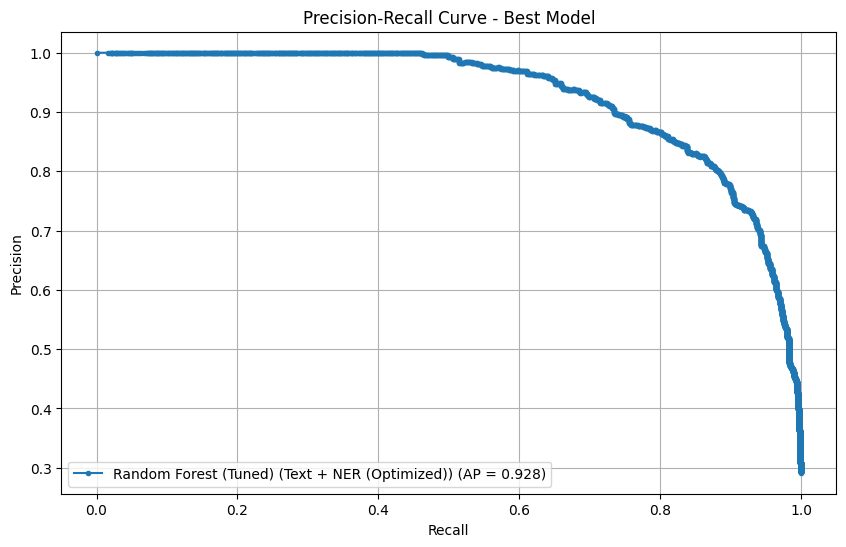

In [28]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, marker='.', 
         label=f'{best_row["Model"]} ({best_feature_type}) (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend()
plt.grid(True)
plt.show()


 Top 20 Most Important Features for Random Forest (Tuned) (Text + NER (Optimized)):

 1. has_both                       : 0.060756
 2. has_drug                       : 0.056715
 3. drug_count                     : 0.055590
 4. disease_count                  : 0.026618
 5. has_disease                    : 0.024245
 6. induced                        : 0.018491
 7. develop                        : 0.008608
 8. associate                      : 0.006651
 9. report                         : 0.005315
10. induce                         : 0.004992
11. patient                        : 0.004577
12. associated                     : 0.004447
13. case                           : 0.004116
14. administration                 : 0.003775
15. treatment                      : 0.003255
16. severe                         : 0.003218
17. toxicity                       : 0.003087
18. therapy                        : 0.003039
19. acute                          : 0.002963
20. syndrome                       : 0.0

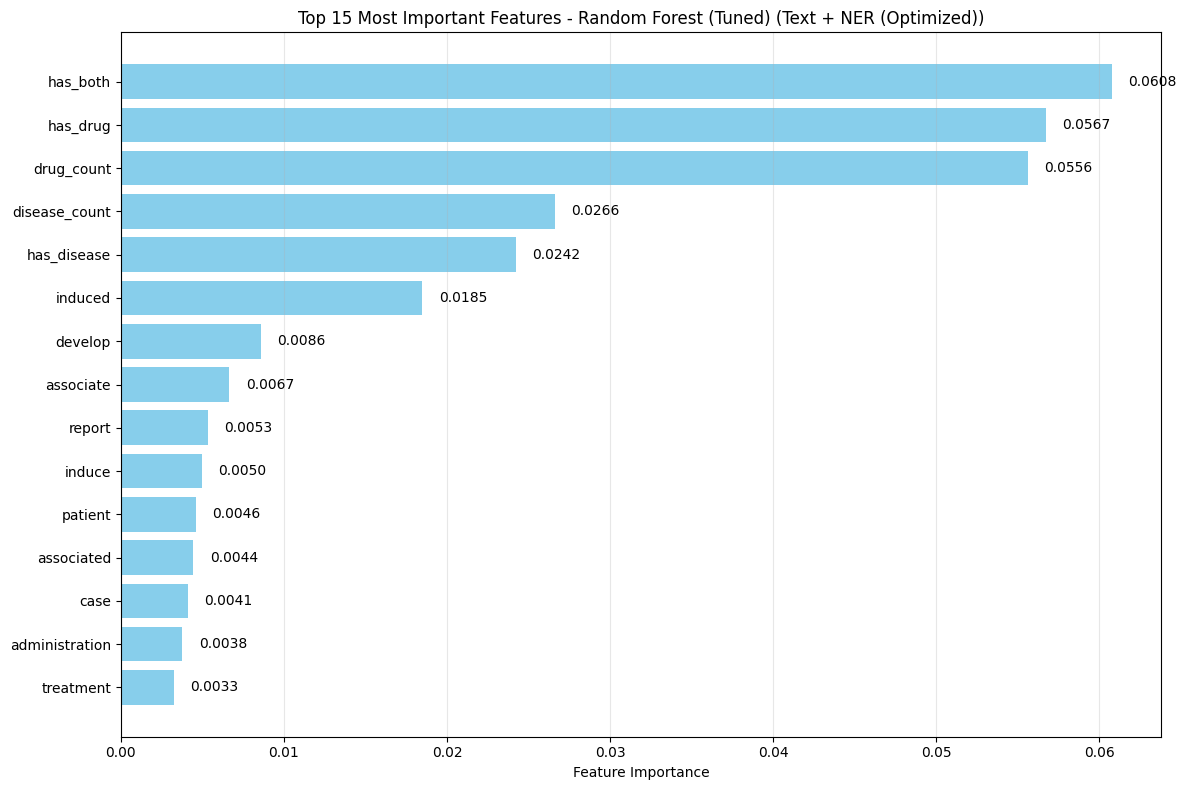

NER FEATURE IMPORTANCE

NER Feature Importances:
  has_drug             : 0.056715
  has_disease          : 0.024245
  drug_count           : 0.055590
  disease_count        : 0.026618
  has_both             : 0.060756


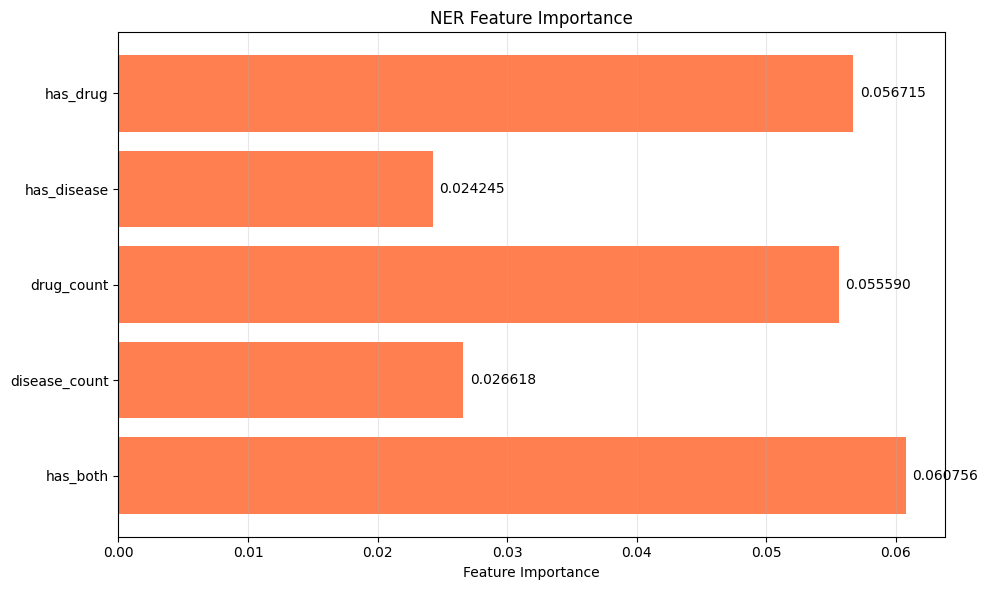

In [29]:
# FEATURE IMPORTANCE ANALYSIS
if 'Random Forest' in best_row['Model']:
    # Handle all Text+NER variants (including optimized)
    if best_feature_type in ['Text + NER', 'Text + NER (Optimized)']:
        # Get the Random Forest model from pipeline
        if hasattr(best_model, 'named_steps'):
            rf_model = best_model.named_steps['classifier']
            feature_importances = rf_model.feature_importances_
            
            # Get feature names - handle both original and bigram transformers
            if hasattr(best_model.named_steps['features'], 'tfidf'):
                text_feature_names = best_model.named_steps['features'].tfidf.get_feature_names_out()
            else:
                # Fallback for any transformer without tfidf attribute
                text_feature_names = [f"feature_{i}" for i in range(len(feature_importances) - 5)]
            
            ner_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
            all_feature_names = list(text_feature_names) + ner_feature_names
        else:
            # If best_model is directly the classifier (shouldn't happen, but just in case)
            rf_model = best_model
            feature_importances = rf_model.feature_importances_
            all_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both'] + \
                               [f"text_feature_{i}" for i in range(len(feature_importances) - 5)]
        
    elif best_feature_type == 'NER Only':
        rf_model = best_model
        feature_importances = rf_model.feature_importances_
        all_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
        
    else:  # Text Only
        rf_model = best_model
        feature_importances = rf_model.feature_importances_
        all_feature_names = list(tfidf.get_feature_names_out())
    
    # Sort feature importances
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    # Print top 20 features
    print(f"\n Top 20 Most Important Features for {best_row['Model']} ({best_feature_type}):\n")
    for i in range(min(20, len(sorted_idx))):
        idx = sorted_idx[i]
        feat_name = all_feature_names[idx] if idx < len(all_feature_names) else f'Feature_{idx}'
        print(f"{i+1:2d}. {feat_name:30s} : {feature_importances[idx]:.6f}")
    
    # Visualize top features
    top_n = min(15, len(feature_importances))
    top_indices = sorted_idx[:top_n]
    top_features = [all_feature_names[i] if i < len(all_feature_names) else f'Feature_{i}' for i in top_indices]
    top_importance = feature_importances[top_indices]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(top_n), top_importance[::-1], color='skyblue')
    plt.yticks(range(top_n), top_features[::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features - {best_row["Model"]} ({best_feature_type})')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_importance[::-1])):
        plt.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{val:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # If NER features are present, show their specific importance
    if best_feature_type in ['Text + NER', 'Text + NER (Optimized)', 'NER Only']:
        print("NER FEATURE IMPORTANCE")
        if best_feature_type in ['Text + NER', 'Text + NER (Optimized)']:
            # For combined models, NER features are at the end
            if hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps['features'], 'tfidf'):
                text_feature_count = len(best_model.named_steps['features'].tfidf.get_feature_names_out())
                ner_importances = feature_importances[text_feature_count:]
            else:
                # If we can't determine, assume last 5 are NER features
                ner_importances = feature_importances[-5:] if len(feature_importances) >= 5 else feature_importances
        else:  # NER Only
            ner_importances = feature_importances
        
        ner_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
        
        print("\nNER Feature Importances:")
        for name, importance in zip(ner_feature_names[:len(ner_importances)], ner_importances):
            print(f"  {name:20s} : {importance:.6f}")
        
        # Visualize NER features
        plt.figure(figsize=(10, 6))
        bars = plt.barh(range(len(ner_importances)), ner_importances[::-1], color='coral')
        plt.yticks(range(len(ner_importances)), ner_feature_names[:len(ner_importances)][::-1])
        plt.xlabel('Feature Importance')
        plt.title('NER Feature Importance')
        plt.grid(axis='x', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, ner_importances[::-1])):
            plt.text(val + 0.0005, bar.get_y() + bar.get_height()/2, 
                     f'{val:.6f}', va='center')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"\n  Feature importance analysis is only available for Random Forest models.")
    print(f"Best model is {best_row['Model']}, which does not provide feature importances.")